In [1]:
import os, random, glob, numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
%matplotlib inline

# ROOT directory of the dataset
ROOT = r"D:\AAAAAENSTA\3A\RO11_Apprentissage_pour_la_robotique\archive"
TRAIN_DIR = os.path.join(ROOT, "train")
TEST_DIR  = os.path.join(ROOT, "test")
IMG_SIZE = 48  

# Emotion classes, same as homework's indices
classes = ["angry","disgust","fear","happy","sad","surprise","neutral"]
label2id = {c:i for i,c in enumerate(classes)}
id2label = {i:c.capitalize() for c,i in label2id.items()}

print("Classes:", classes)


Classes: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


In [2]:
def load_image(path, size=IMG_SIZE):
    img = Image.open(path).convert("L").resize((size, size), Image.BILINEAR)
    return np.asarray(img, dtype=np.float32) / 255.0

def build_split(split_dir):
    X_list, y_list, p_list = [], [], []
    for cls in classes:
        folder = os.path.join(split_dir, cls)
        files = glob.glob(os.path.join(folder, "*.jpg"))
        for fp in files:
            img = load_image(fp)
            X_list.append(img.reshape(-1))
            y_list.append(label2id[cls])
            p_list.append(fp)
    X = np.stack(X_list, axis=0) if X_list else np.empty((0, IMG_SIZE*IMG_SIZE), dtype=np.float32)
    y = np.array(y_list, dtype=np.int64)
    return X, y, p_list

X_train, y_train, train_paths = build_split(TRAIN_DIR)
X_test,  y_test,  test_paths  = build_split(TEST_DIR)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape,  y_test.shape)


Train: (28709, 2304) (28709,)
Test : (7178, 2304) (7178,)


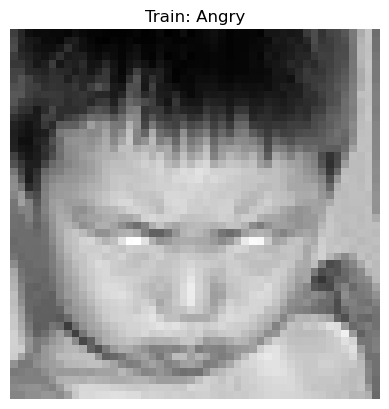

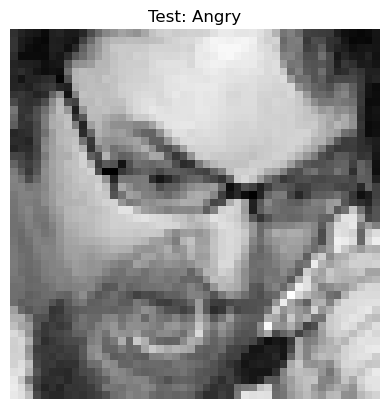

In [3]:
# show one train pic
plt.imshow(X_train[0].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
plt.title(f"Train: {id2label[int(y_train[0])]}")
plt.axis("off")
plt.show()

# 1 test pic
plt.imshow(X_test[0].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
plt.title(f"Test: {id2label[int(y_test[0])]}")
plt.axis("off")
plt.show()


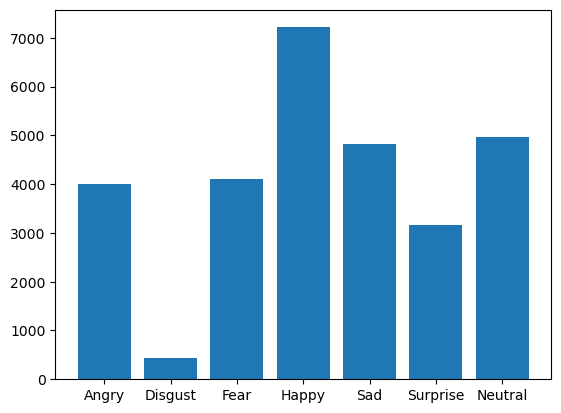

In [4]:
def class_dist(y):
    counts = pd.Series(y).value_counts().sort_index()
    labels = [id2label[i] for i in counts.index]
    plt.bar(labels, counts.values)
    plt.show()

class_dist(y_train)


In [5]:
# use LBP 
# NOTE: The texture style of the entire image can be described by the "frequency of occurrence of various codes: histogram.

def extract_lbp_features(X, P=10, R=2, method="uniform"): # P: number of points on circle, R: radius

    feats = []
    for i in range(X.shape[0]):
        img = X[i].reshape(IMG_SIZE, IMG_SIZE)
        lbp = local_binary_pattern(img, P, R, method)
        (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, P+3),range=(0, P+2))
        # normalise
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        feats.append(hist)
    return np.array(feats) # (N, hist_dim)


In [6]:
# extract feat
# I tried 2 different ways to build training set. One is to create a balanced set with 500/2000/4000 samples per class. The other is to use all training samples (unbalanced).
# Then I realized that the 2nd method is way better than the first one. 
# It's a little bit controversial because the model may be biased towards the majority classes, but perhaps there's no kind of "neurones" so that makes sense.

'''
# Method 1: Balanced
def sample_per_class(X, y, per_class=4000, seed=42):
    rng = np.random.default_rng(seed)
    idx_all = []
    for c in np.unique(y):
        idx_c = np.where(y == c)[0]
        k = min(per_class, len(idx_c))
        idx_all.extend(rng.choice(idx_c, k, replace=False))
    idx_all = np.array(idx_all)
    return X[idx_all], y[idx_all]

# ---- training: 500 per class ----
Xtr, Ytr = sample_per_class(X_train, y_train, per_class=4000, seed=42)
Xtr_lbp = extract_lbp_features(Xtr)

# ---- testing: all test samples ----
Xte_lbp = extract_lbp_features(X_test)
Yte = y_test
'''

# Method 2: Imbalanced
Xtr_lbp = extract_lbp_features(X_train)
Ytr = y_train

Xte_lbp = extract_lbp_features(X_test)
Yte = y_test


c:\Users\82062\anaconda3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [7]:

# Train KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def chi2_distance(a, b):
    return 0.5 * np.sum(((a - b) ** 2) / (a + b + 1e-10))

# knn = KNeighborsClassifier(n_neighbors=5, metric=chi2_distance) 
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(Xtr_lbp, Ytr)

# Test
y_pred = knn.predict(Xte_lbp)
acc = accuracy_score(Yte, y_pred)
print("LBP + KNN accuracy:", acc)


LBP + KNN accuracy: 0.25048760100306494


<Figure size 640x480 with 0 Axes>

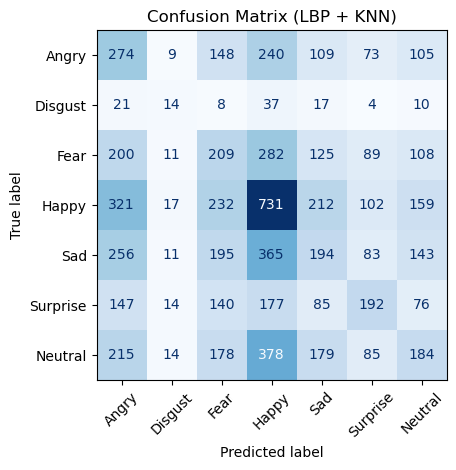

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# force all 7 classes in the matrix
cm = confusion_matrix(Yte, y_pred, labels=range(len(classes)))

# fresh figure avoids inherited ticks
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in range(len(classes))])
disp.plot(cmap="Blues", xticks_rotation=45, colorbar=False)
plt.title("Confusion Matrix (LBP + KNN)")
plt.tight_layout()
plt.show()


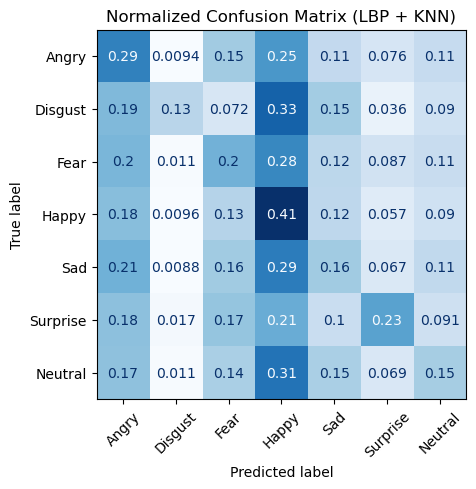

In [9]:
import numpy as np
cm = confusion_matrix(Yte, y_pred, labels=range(len(classes)))

cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[id2label[i] for i in range(len(classes))])
disp.plot(cmap="Blues", xticks_rotation=45, colorbar=False)
plt.title("Normalized Confusion Matrix (LBP + KNN)")
plt.show()

In [ ]:
import joblib

joblib.dump(knn, "lbp_knn.pkl")
print("save at lbp_knn.pkl")

save at lbp_knn.pkl
